In [1]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# device_lib.list_local_devices()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, classification_report

In [3]:
data_dir = (r'D:\Rostock-Masters\Thesis\Test')
data_dir

'D:\\Rostock-Masters\\Thesis\\Test'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('D:/Rostock-Masters/Thesis/Test')

In [5]:
file_name_dict = {
    'Device_1' : list(data_dir.glob('Device_1/*.csv')),
    'Device_2' : list(data_dir.glob('Device_2/*.csv')),
    'Device_3' : list(data_dir.glob('Device_3/*.csv')),
    'Device_4' : list(data_dir.glob('Device_4/*.csv')),
    'Device_5' : list(data_dir.glob('Device_5/*.csv')),
    'Device_6' : list(data_dir.glob('Device_6/*.csv'))
}

In [6]:
file_label_dict = {
    'Device_1' : 0,
    'Device_2' : 1,
    'Device_3' : 2,
    'Device_4' : 3,
    'Device_5' : 4,
    'Device_6' : 5,
}

In [7]:
len(file_name_dict['Device_4'])

100

In [8]:
str(file_name_dict['Device_3'][0])

'D:\\Rostock-Masters\\Thesis\\Test\\device_3\\3_8_5_3_8_5-1.csv'

### Classification

In [9]:
file_name_dict_2 = {
    'Device_1' : list(data_dir.glob('Device_1/*.csv')),
    'Device_2' : list(data_dir.glob('Device_2/*.csv'))
}

In [10]:
file_label_dict_2 = {
    'Device_1' : 0,
    'Device_2' : 1
}

In [11]:
df= pd.read_csv('3_8_1_3_8_1-1.csv')
df.columns = ['time', 'voltage']
df.head()

,time,voltage
0,0.0,32.965541
1,0.5,32.914965
2,1.0,32.904850
3,1.5,32.864389
4,2.0,32.854273


In [12]:
df['MA'] = df['voltage'].rolling(10,min_periods=0).mean()
df.head()

,time,voltage,MA
0,0.0,32.965541,32.965541
1,0.5,32.914965,32.940253
2,1.0,32.904850,32.928452
3,1.5,32.864389,32.912436
4,2.0,32.854273,32.900804


### Preprocessing

In [14]:
device_list, device_label = [],[]   #compressed

for device_name, folder in file_name_dict.items():
    for file in folder:
        file_df = pd.read_csv(str(file))
        file_df.columns = ['time', 'voltage']
        
        #Replacing originial values with moving average values
        file_df['MA'] = file_df['voltage'].rolling(10,min_periods=0).mean()# moving average
        file_df= file_df.drop('voltage',axis=1)
        file_df.rename(columns={'MA':'voltage'},inplace=True)
        
        #Split and shift function
        threshold = file_df['voltage'].diff().gt(1)
        group = (threshold&~threshold.shift(fill_value=False)).cumsum().add(1)
        time= lambda i: i['time'].groupby(group).apply(lambda j: j- j.iloc[0])
        df_2 = (file_df.assign(bit=group,time=time).pivot(index='bit', columns='time', values='voltage'))
        df_3 = df_2.copy()
        df_3.reset_index(drop=True, inplace=True)
        df_3 = df_3.rename_axis(None, axis=1)

        #Compressing to  10 rows 100 columns
        df_4=df_3.iloc[:10, :100]
        
        #Filling out empty cells
        df_4= df_4.fillna(method='pad')
        device_list.append(df_4)
        device_label.append(file_label_dict[device_name])

In [15]:
# # #Saving files to folder
# for i in range (len(device_list)):
#         device_list[i].to_csv('after_MA/file-{}.csv'.format(i))

In [16]:
device_list[420]

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,45.0,45.5,46.0,46.5,47.0,47.5,48.0,48.5,49.0,49.5
0,31.215606,31.210548,31.208862,31.197904,31.197399,31.183574,31.179480,31.159972,31.148171,31.128615,...,28.879999,28.111241,27.202893,26.407836,25.586479,24.800526,24.008503,23.209400,22.404227,21.782141
1,26.825595,27.934225,29.085338,30.257693,31.256067,31.861969,32.409203,32.794594,33.128396,33.423761,...,31.417911,31.389588,31.363288,31.336989,31.307655,31.278320,31.251009,31.221675,31.197399,31.168064
2,25.914213,26.991485,28.108207,29.280562,30.477194,31.504902,32.124965,32.688384,33.072763,33.418703,...,31.617181,31.585823,31.554466,31.523109,31.494786,31.464441,31.437130,31.407795,31.383519,31.355196
3,25.863637,26.987439,28.104161,29.290677,30.502482,31.547386,32.178576,32.745029,33.145592,33.491533,...,31.683941,31.647526,31.623250,31.585823,31.558512,31.522097,31.502879,31.465452,31.445222,31.405772
4,25.966812,27.041050,28.195198,29.364518,30.577335,31.619204,32.241290,32.812801,33.208307,33.551213,...,31.685964,31.657642,31.625273,31.596950,31.566604,31.543339,31.511982,31.485683,31.452302,31.430049
5,28.425825,29.490959,30.418526,30.969806,31.482648,31.846796,32.150253,32.431457,32.671188,32.889677,...,30.839319,30.812008,30.789755,30.760420,30.742213,30.718948,30.698718,30.674441,30.654211,30.631957
6,27.431498,28.444032,29.510178,30.455952,31.012290,31.533224,31.890292,32.199818,32.460791,32.705580,...,30.854492,30.829204,30.798858,30.777616,30.750305,30.716925,30.698718,30.667360,30.648141,30.622853
7,26.692074,27.777439,28.921471,30.090792,31.146822,31.760817,32.340420,32.732891,33.071751,33.382289,...,31.407795,31.379473,31.333954,31.317770,31.272251,31.251009,31.219652,31.193352,31.169076,31.137719
8,25.795865,26.868079,27.993905,29.155133,30.347719,31.432072,32.057193,32.649946,33.044440,33.400496,...,31.611111,31.581777,31.551432,31.520074,31.493775,31.461406,31.428026,31.397680,31.372392,31.343058
9,25.720000,26.826607,27.948386,29.138949,30.339627,31.449268,32.086527,32.690407,33.101085,33.452084,...,31.675849,31.644492,31.605042,31.577731,31.543339,31.517040,31.485683,31.453314,31.429037,31.398692


In [17]:
len(device_list)

600

In [18]:
len(device_label)

600

In [19]:
device_list[120].shape

(10, 100)

In [20]:
#Find unique values in device label
device_label_set= set(device_label)
device_label_set

{0, 1, 2, 3, 4, 5}

In [21]:
device_label[395:405]

[3, 3, 3, 3, 3, 4, 4, 4, 4, 4]

In [22]:
#Converting to numpy array
X = np.array(device_list)
y = np.array(device_label)

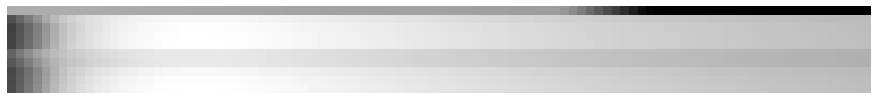

In [56]:
plt.figure(figsize = (15, 10))
plt.imshow(np.squeeze(X[1]),cmap='gray' )# cmap='gray'
plt.axis('off')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

plt.savefig('time_series_greyscale.png', bbox_inches= 'tight',pad_inches = 0, dpi=300)
plt.show()

In [23]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30,random_state=42,stratify=y)

In [24]:
X_train.shape

(420, 10, 100)

In [25]:
X_test.shape

(180, 10, 100)

In [26]:
len(X_train)

420

In [27]:
#Adding 1 dimension
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [28]:
#Print shapes
print('Train tensor shape: ',X_train.shape)
print('Test tensor shape: ',X_test.shape)
print('Single image shape:', X_train[0].shape)
print('Train_labels shape:', y_train.shape)
print('Test_labels shape:', y_test.shape)

Train tensor shape:  (420, 10, 100, 1)
Test tensor shape:  (180, 10, 100, 1)
Single image shape: (10, 100, 1)
Train_labels shape: (420,)
Test_labels shape: (180,)


In [29]:
#scaling data from 0 to 1
X_train_scaled = X_train/36 #Max voltage value 36
X_test_scaled = X_test/36

In [30]:
X_train_scaled[101].shape

(10, 100, 1)

In [31]:
# X_train_scaled[419]

In [32]:
y_test[5:25]

array([0, 3, 2, 3, 2, 1, 1, 1, 5, 0, 5, 4, 0, 0, 2, 5, 1, 0, 2, 3])

In [33]:
#Set random seed
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding="same", activation='relu',kernel_initializer='normal',
                           input_shape=(X_train_scaled[0].shape)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    
    
    tf.keras.layers.Conv2D(16,3, padding="same", activation='relu',kernel_initializer='normal',),
    tf.keras.layers.MaxPool2D(pool_size=2),
    
    tf.keras.layers.Conv2D(32,3, padding="same", activation='relu',kernel_initializer='normal',),
    tf.keras.layers.MaxPool2D(pool_size=2),
    

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(128,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(6, activation= 'softmax') #Output layer

])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 100, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 50, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 50, 16)         1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 25, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 25, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 12, 32)        0

In [34]:
# tf.keras.utils.plot_model(model_2, show_shapes=True)

In [35]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
                metrics= ['accuracy'])
              
history= model_2.fit(X_train_scaled, y_train, epochs=300, batch_size=32,validation_split=0.20, verbose=1, shuffle= True) #validation_split=0.33
history

Epoch 1/300
11/11 [==============================] - 8s 38ms/step - loss: 1.7920 - accuracy: 0.1399 - val_loss: 1.7936 - val_accuracy: 0.1071
Epoch 2/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7914 - accuracy: 0.1815 - val_loss: 1.7942 - val_accuracy: 0.1071
Epoch 3/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7912 - accuracy: 0.1815 - val_loss: 1.7957 - val_accuracy: 0.1071
Epoch 4/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7911 - accuracy: 0.1815 - val_loss: 1.7994 - val_accuracy: 0.1071
Epoch 5/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7908 - accuracy: 0.1815 - val_loss: 1.8010 - val_accuracy: 0.1071
Epoch 6/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7904 - accuracy: 0.1815 - val_loss: 1.8028 - val_accuracy: 0.1071
Epoch 7/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7920 - accuracy: 0.1815 - val_loss: 1.8059 - val_accuracy: 0.1071
Epoch 8/300


Epoch 59/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7892 - accuracy: 0.1815 - val_loss: 1.8070 - val_accuracy: 0.1071
Epoch 60/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7889 - accuracy: 0.1815 - val_loss: 1.8090 - val_accuracy: 0.1071
Epoch 61/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7882 - accuracy: 0.1815 - val_loss: 1.8089 - val_accuracy: 0.1071
Epoch 62/300
11/11 [==============================] - 0s 5ms/step - loss: 1.7869 - accuracy: 0.1815 - val_loss: 1.8102 - val_accuracy: 0.1071
Epoch 63/300
11/11 [==============================] - 0s 6ms/step - loss: 1.7843 - accuracy: 0.1815 - val_loss: 1.8086 - val_accuracy: 0.1071
Epoch 64/300
11/11 [==============================] - 0s 6ms/step - loss: 1.7807 - accuracy: 0.1815 - val_loss: 1.8016 - val_accuracy: 0.1071
Epoch 65/300
11/11 [==============================] - 0s 6ms/step - loss: 1.7683 - accuracy: 0.1815 - val_loss: 1.7858 - val_accuracy: 0.1071
Epoch 

11/11 [==============================] - 0s 5ms/step - loss: 0.9002 - accuracy: 0.5625 - val_loss: 0.8793 - val_accuracy: 0.4881
Epoch 174/300
11/11 [==============================] - 0s 5ms/step - loss: 0.9053 - accuracy: 0.5506 - val_loss: 0.9481 - val_accuracy: 0.5952
Epoch 175/300
11/11 [==============================] - 0s 5ms/step - loss: 0.9501 - accuracy: 0.5149 - val_loss: 0.9243 - val_accuracy: 0.5714
Epoch 176/300
11/11 [==============================] - 0s 5ms/step - loss: 0.9229 - accuracy: 0.5238 - val_loss: 0.9212 - val_accuracy: 0.5714
Epoch 177/300
11/11 [==============================] - 0s 5ms/step - loss: 0.9173 - accuracy: 0.5565 - val_loss: 0.8814 - val_accuracy: 0.4881
Epoch 178/300
11/11 [==============================] - 0s 6ms/step - loss: 0.8971 - accuracy: 0.5804 - val_loss: 0.8672 - val_accuracy: 0.5000
Epoch 179/300
11/11 [==============================] - 0s 5ms/step - loss: 0.9017 - accuracy: 0.5774 - val_loss: 0.8881 - val_accuracy: 0.4762
Epoch 180/300

11/11 [==============================] - 0s 5ms/step - loss: 0.8488 - accuracy: 0.5506 - val_loss: 0.9005 - val_accuracy: 0.5238
Epoch 288/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8521 - accuracy: 0.5774 - val_loss: 0.9017 - val_accuracy: 0.4405
Epoch 289/300
11/11 [==============================] - 0s 5ms/step - loss: 0.8496 - accuracy: 0.5476 - val_loss: 0.8665 - val_accuracy: 0.5476
Epoch 290/300
11/11 [==============================] - 0s 6ms/step - loss: 0.8421 - accuracy: 0.5863 - val_loss: 0.8608 - val_accuracy: 0.5714
Epoch 291/300
11/11 [==============================] - 0s 6ms/step - loss: 0.8637 - accuracy: 0.5357 - val_loss: 0.9152 - val_accuracy: 0.5476
Epoch 292/300
11/11 [==============================] - 0s 6ms/step - loss: 0.8658 - accuracy: 0.5327 - val_loss: 0.8855 - val_accuracy: 0.5357
Epoch 293/300
11/11 [==============================] - 0s 6ms/step - loss: 0.9099 - accuracy: 0.5149 - val_loss: 0.8777 - val_accuracy: 0.6071
Epoch 294/300

In [36]:
print('Validation accuracy : ', (np.mean(history.history['val_accuracy'][-50:]))*100, '%') # Mean of last 50 values

Validation accuracy :  52.78571516275405 %


In [37]:
loss, accuracy= model_2.evaluate(X_test_scaled, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
print('Test accuracy : ',accuracy*100,'%')

6/6 [==============================] - 0s 2ms/step - loss: 0.8840 - accuracy: 0.5000
Loss: 0.8840450644493103, Accuracy: 0.5
Test accuracy :  50.0 %


In [38]:
# model_2.save('6_device_saved_model.h5')

In [39]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


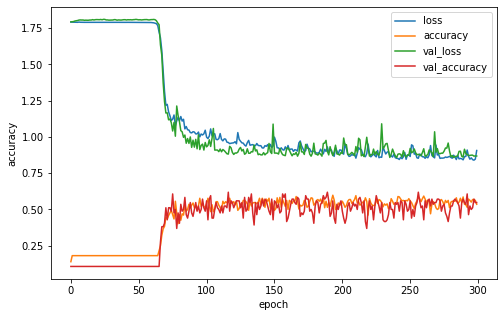

In [40]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('6_acc_loss_56.pdf',bbox_inches = 'tight', pad_inches = 0, dpi= 100)
plt.show()

In [41]:
np.set_printoptions(suppress=True)
y_pred = model_2.predict(X_test_scaled)
# y_pred[:10]

6/6 [==============================] - 0s 2ms/step


In [42]:
y_pred_class = [np.argmax(i) for i in y_pred]
y_pred_class[:10]

[3, 4, 4, 5, 1, 0, 3, 3, 3, 4]

In [43]:
y_test[:10]

array([4, 2, 3, 5, 1, 0, 3, 2, 3, 2])

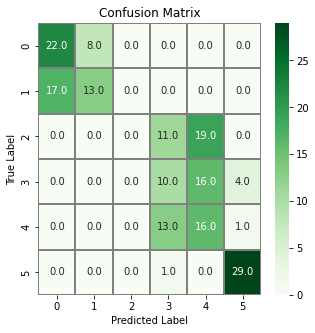

In [44]:
#Confusion matrix
import seaborn as sns
cm=confusion_matrix(y_test,y_pred_class)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=file_label_dict_2)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# disp.plot(ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig('conf_6_device_class_56.pdf',bbox_inches = 'tight', pad_inches = 0, dpi= 100)
plt.show()

In [45]:
loss, accuracy= model_2.evaluate(X_test_scaled, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
print('Test accuracy : ',accuracy*100,'%')

6/6 [==============================] - 0s 2ms/step - loss: 0.8840 - accuracy: 0.5000
Loss: 0.8840450644493103, Accuracy: 0.5
Test accuracy :  50.0 %


In [46]:
# clf_report= classification_report(y_test, y_pred_class)
# print(clf_report)

C:\Users\mail2\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail2\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail2\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

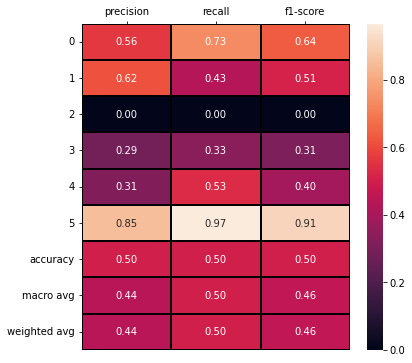

In [47]:
clf_report= classification_report(y_test, y_pred_class,output_dict=True)

 #.iloc[:-1, :] to exclude support
fig, ax = plt.subplots(figsize=(6,6))

# sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues",linecolor="black", fmt= '.2f')
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,linewidths=0.01,linecolor="black", fmt= '.2f')# cmap="Blues",
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
# plt.savefig('clf_6_device_class_56.pdf',bbox_inches = 'tight', pad_inches = 0, dpi= 100)
plt.show()